# Deep Learning course 2022-2023
## Project: Video Prediction on Moving MNIST
### Project Contributors
* Mattia Castelmare, 1815675
* Andrea Giuseppe Di Francesco, 1836928
* Enrico Fazzi, 2003876

#### Installation cells

In [1]:
# !git clone https://github.com/tychovdo/MovingMNIST.git
# !wget http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
# !pip3 install torchvision
# !pip3 install matplotlib
# !pip install wandb
# !pip install pytorch-lightning==1.5.10

--2023-02-09 13:00:48--  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819200096 (781M)
Saving to: ‘mnist_test_seq.npy’

mnist_test_seq.npy  100%[===================>] 781,25M  9,15MB/s    in 82s     

2023-02-09 13:02:11 (9,55 MB/s) - ‘mnist_test_seq.npy’ saved [819200096/819200096]



### Importing Libraries

In [2]:
### wandb codes ###
import wandb
#####################

import torch
import os
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning import Trainer
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from MovingMNIST.MovingMNIST import *
# from pytorch_msssim import ssim, SSIM
rc('animation', html='jshtml')


/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Useful Functions

In [3]:
def show_video(tensor):
    ''' This function display a video, given a torch tensor (source: https://stackoverflow.com/questions/67261108/how-to-display-a-video-in-colab-using-a-pytorch-tensor-of-rgb-image-arrays)
        INPUT: tensor (Frames x Channels x Height x Width) 
        OUTPUT: Display an animation '''

    fig, ax = plt.subplots()

    imgs = tensor
    imgs = imgs.permute(0, 2, 3, 1)  # Permuting to (Bx)HxWxC format
    frames = [[ax.imshow(imgs[i], cmap='gray')] for i in range(len(imgs))]

    ani = animation.ArtistAnimation(fig, frames)
    return ani


def collate(batch):
    ''' This function is used within the Dataloader pytorch utility. 
        INPUT: batch: List of tuples of tensor, each tuple contains the input video and the target video, 
        OUTPUT: A tuple (input, gt), s.t. both of them has dimension (B x T x C x H x W)'''

    list_tuples = list(map(lambda x: (torch.reshape(x[0], (1, x[0].shape[0], 1, x[0].shape[1], x[0].shape[2])), torch.reshape(
        x[1], (1, x[1].shape[0], 1, x[1].shape[1], x[1].shape[2]))), batch))

    input = list_tuples[0][0]
    gt = list_tuples[0][1]

    for i in range(1, len(list_tuples)):
        input = torch.cat((input, list_tuples[i][0]), dim=0)
        gt = torch.cat((gt, list_tuples[i][1]), dim=0)

    return ((input/255).type(torch.FloatTensor), (gt/255).type(torch.FloatTensor))


def save_model(model, loss, path):
  # This function is a customized in order to save a pytorch model.
    checkpoint = {'model_state': model.state_dict(),
                  'loss': loss}
    torch.save(checkpoint, path)


def load_model(path, model):
  # This function loads a pytorch model from a path.
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state'])

    return checkpoint


def stride_generator(N, reverse=False):
    ''' This function is desired to know what is the list of stride values to use when defining an E-D architecture, it was taken by https://github.com/gaozhangyang/SimVP-Simpler-yet-Better-Video-Prediction. '''
    strides = [1, 2]*10
    if reverse:
        return list(reversed(strides[:N]))
    else:
        return strides[:N]


def kronecker_product(dyn, static):
    """ This function is a fast implementation of the kronocker product mentioned in the paper https://arxiv.org/pdf/2206.12126.pdf.
        The original implementation, from which we took inspiration is available at https://gist.github.com/yulkang/4a597bcc5e9ccf8c7291f8ecb776382d.
        INPUTs:
            -dyn: results of the dynamical attention module: (B, T*C, 1, 1),
            -static: results of the static attention module: (B, T*C, 32, 32).
        OUTPUTs:
            - res: Kronocker product result.
    """
    siz1 = torch.Size(torch.tensor(
        dyn.shape[-2:]) * torch.tensor(static.shape[-2:]))
    res = dyn.unsqueeze(-1).unsqueeze(-3) * static.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    return res.reshape(siz0 + siz1)


### Useful variables 

In [4]:
shuffle_train = True
shuffle_test = False
download = True

### wandb codes ###
wb = True
project_name = "VP_on_MMNIST"
if wb:
    wandb.login()
###################

SEED = 2812023
pl.seed_everything(SEED)

root = './data'
if not os.path.exists(root):
    os.mkdir(root)
test_data = np.load('mnist_test_seq.npy')


wandb: Currently logged in as: difra00 (deepl_wizards). Use `wandb login --relogin` to force relogin
Global seed set to 2812023


### Pytorch lightning DataModule:
* Set the MMNIST Dataset object and Dataloader 

In [12]:
class TestDataset(Dataset):

    def __init__(self, test_data):
        self.test_data = test_data
        self.test_data = self.process_image()
    def process_image(self):
        self.test_data = torch.tensor(self.test_data)
        self.input =  self.test_data[:10].permute(1, 0, 2, 3)
        self.input_ = self.input.reshape(self.input.shape[0], self.input.shape[1], 1, self.input.shape[2], self.input.shape[3])
        self.gt =  self.test_data[10:].permute(1, 0, 2, 3)
  
        self.gt_ =  self.gt.reshape(self.gt.shape[0], self.gt.shape[1], 1, self.gt.shape[2], self.gt.shape[3])
    
    def __len__(self):
        return self.input_.shape[0]
    def __getitem__(self, idx):
        return (self.input_[idx]/255).type(torch.FloatTensor), (self.gt_[idx]/255).type(torch.FloatTensor) 

class pl_Dataset(pl.LightningDataModule):

    def __init__(self, batch_size):

        self.bs = batch_size

    def setup(self, stage=None):
        if stage == 'fit':
            self.train_set = MovingMNIST(root=root,
                                         train=True,
                                         download=download)
        elif stage == 'test':
            # self.test_set = MovingMNIST(root=root,
            #                             train=False,
            #                             download=download)
            self.test_set = TestDataset(test_data)

    def train_dataloader(self, *args, **kwargs):

        train_loader = torch.utils.data.DataLoader(
            dataset=self.train_set,
            batch_size=self.bs,
            shuffle=shuffle_train,
            collate_fn=collate)

        return train_loader

    def val_dataloader(self, *args, **kwargs):

        # test_loader = torch.utils.data.DataLoader(
        #     dataset=self.test_set,
        #     batch_size=self.bs,
        #     shuffle=shuffle_test,
        #     collate_fn=collate)

        test_loader = DataLoader(self.test_set, shuffle = shuffle_test, batch_size = self.bs)

        return test_loader


### Hyperparameters

In [13]:
batch_size = 16
lr = 1e-2
wd = 5e-2
dataset_length = 10000
epochs = 100

tau = 1e-1 # KL Divergency parameter


### Vanilla hyperparameters ###

hyperparametersS = {'lr': lr,
                    'wd': wd,
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'CNN': {'input': 1,
                            'hidden_S': 64,  # Output channels in Encoder / Input channel in Decoder
                            'output_T': 512,  # Output channels in Inception, Hidden C. == Output channels // 2
                            'ksize': 3,
                            'Ns': 4,
                            'Nt': 3}
                    }

hyperparametersT = {'lr': lr,
                    'wd': wd,
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'CNN': {'input': 1,
                            'hidden_S': 64,
                            'ksize': 3
                            },
                    'n_layers': 4
                    }


data = pl_Dataset(batch_size)

data.setup(stage='fit')
data.setup(stage='test')


# Models

### Our VanillaED (Enry and Matty)
* Implementation of a Vanilla Encoder Decoder architecture with a skip connection

In [14]:
# Some of the following functions are inspired by https://github.com/gaozhangyang/SimVP-Simpler-yet-Better-Video-Prediction.

class VConvBlock(nn.Module):

    def __init__(self, inputC, outputC, stride=None, padding='same', transpose=False, kernel=hyperparametersT['CNN']['ksize']):
        super(VConvBlock, self).__init__()

        if not transpose:
           self.conv = nn.Conv2d(
                    inputC, outputC, kernel_size=kernel, padding=padding, stride=stride)
        else:
            self.conv = nn.ConvTranspose2d(
                inputC, outputC, kernel, stride=stride, padding=1, output_padding=stride // 2)

        self.layernorm = nn.GroupNorm(2, outputC)
        self.activation = nn.ReLU(inplace = True)

    def forward(self, x):

        x = self.conv(x)
        
        x = self.layernorm(x)

        x = self.activation(x)


        return x


class VEncoder(nn.Module):

    def __init__(self, n_layers):
        super(VEncoder, self).__init__()
        strides = stride_generator(n_layers)
        layers = [VConvBlock(hyperparametersS['CNN']['input'], hyperparametersS['CNN']
                            ['hidden_S'], stride=strides[0], padding=1)]

        for layer in range(1, n_layers):
            stride = strides[layer]
            layers.append(VConvBlock(
                hyperparametersT['CNN']['hidden_S'], hyperparametersT['CNN']['hidden_S'], stride=stride, padding=1))

        self.enc = nn.Sequential(*layers)

    def forward(self, x):

        B, T, C, H, W = x.shape

        x = x.reshape((B*T, C, H, W))

        skip = self.enc[0](x)
        x = self.enc(x)


        return x, skip



class VDecoder(nn.Module):

    def __init__(self, n_layers):
        super(VDecoder, self).__init__()
        strides = stride_generator(n_layers, reverse=True)
        layers = []
        for layer in range(n_layers-1):
            stride = strides[layer]
            layers.append(VConvBlock(hyperparametersT['CNN']['hidden_S'], hyperparametersT['CNN']
                          ['hidden_S'], transpose=True, stride=stride, padding=1))

        layers.append(VConvBlock(2*hyperparametersT['CNN']['hidden_S'], hyperparametersT['CNN']
                      ['hidden_S'], transpose=True, stride=strides[-1], padding=1))

        self.proj = nn.Conv2d(
            hyperparametersT['CNN']['hidden_S'], hyperparametersS['CNN']['input'], 1)

        self.dec = nn.Sequential(*layers)

    def forward(self, x, skip):

        for l_idx in range(len(self.dec)-1):
            x = self.dec[l_idx](x)

        x = self.dec[-1](torch.cat((x, skip), dim=1))
        x = self.proj(x)

        return x
class VEncoderDecoder(nn.Module):
    def __init__(self):
        super(VEncoderDecoder, self).__init__()


        self.encoder = VEncoder(hyperparametersS['CNN']['Ns'])
        self.decoder = VDecoder(hyperparametersS['CNN']['Ns'])


    def forward(self, input):
        B, T, C, H, W = input.shape
        output, skip = self.encoder(input)


        output = self.decoder(output, skip)
        
        output = output.reshape((B, T, C, H, W))

        return output

#### SimVP
* Implementation of the SimVP architecture, the details are available at https://arxiv.org/pdf/2206.05099.pdf,
* Encoder (CNN) +  Translator (Inception) + Decoder (CNN) 
* The implementation details were taken by the original implementation https://github.com/gaozhangyang/SimVP-Simpler-yet-Better-Video-Prediction , since some of them were neglected in the paper.

In [15]:
# Some of the following functions are inspired by https://github.com/gaozhangyang/SimVP-Simpler-yet-Better-Video-Prediction.

class ConvBlock(nn.Module):

    def __init__(self, inputC, outputC, stride=None, padding='same', transpose=False, groups=8, kernel=hyperparametersS['CNN']['ksize'], incep = False):
        super(ConvBlock, self).__init__()
        if inputC % groups != 0:
            groups = 1


        if not transpose:
            if incep:
                self.conv = nn.Conv2d(
                    inputC, outputC, kernel_size=kernel, padding=padding, stride=stride, groups = groups)
            else:
                self.conv = nn.Conv2d(
                    inputC, outputC, kernel_size=kernel, padding=padding, stride=stride)
        else:
            self.conv = nn.ConvTranspose2d(
                inputC, outputC, kernel, stride=stride, padding=1, output_padding=stride // 2)

        self.layernorm = nn.GroupNorm(groups, outputC)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):

        x = self.leaky(self.layernorm(self.conv(x)))

        return x


class EncoderSimVP(nn.Module):

    def __init__(self, n_layers):
        super(EncoderSimVP, self).__init__()
        strides = stride_generator(n_layers)
        layers = [ConvBlock(hyperparametersS['CNN']['input'], hyperparametersS['CNN']
                            ['hidden_S'], groups=2, stride=strides[0], padding=1)]

        for layer in range(1, n_layers):
            stride = strides[layer]
            layers.append(ConvBlock(
                hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']['hidden_S'], groups=2, stride=stride, padding=1))

        self.enc = nn.Sequential(*layers)

    def forward(self, x):

        B, T, C, H, W = x.shape

        x = x.reshape((B*T, C, H, W))

        skip = self.enc[0](x)
        x = self.enc(x)

        # x = x.reshape((B, T, hyperparameters['CNN']['hidden_S'], H, W))

        return x, skip



class DecoderSimVP(nn.Module):

    def __init__(self, n_layers):
        super(DecoderSimVP, self).__init__()
        strides = stride_generator(n_layers, reverse=True)
        layers = []
        for layer in range(n_layers-1):
            stride = strides[layer]
            layers.append(ConvBlock(hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']
                          ['hidden_S'], transpose=True, groups=2, stride=stride, padding=1))

        layers.append(ConvBlock(2*hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']
                      ['hidden_S'], transpose=True, groups=2, stride=strides[-1], padding=1))

        self.proj = nn.Conv2d(
            hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']['input'], 1)

        self.dec = nn.Sequential(*layers)

    def forward(self, x, skip):

        for l_idx in range(len(self.dec)-1):
            x = self.dec[l_idx](x)

        x = self.dec[-1](torch.cat((x, skip), dim=1))
        x = self.proj(x)

        return x



class InceptionModule(nn.Module):

    def __init__(self, inputC, outputC, kernel_list=[3, 5, 7, 11], groups=8):
        super(InceptionModule, self).__init__()

        hiddenC = outputC // 2

        self.Conv = nn.Conv2d(
            inputC, hiddenC, kernel_size=1, stride=1, padding=0)

        layers = []

        for kernel in kernel_list:
            layers.append(ConvBlock(hiddenC, outputC, groups=groups,
                          stride=1, padding=kernel // 2, kernel=kernel, incep = True))

        self.ConvParallel = nn.Sequential(*layers)

    def forward(self, input):

        x = self.Conv(input)

        output = 0

        for conv in self.ConvParallel:

            output += conv(x)

        return output



    
class Translator(nn.Module):

    def __init__(self, n_layers, inputC):
        super(Translator, self).__init__()

        self.n_layers = n_layers
        enc_layers = [InceptionModule(
            inputC, hyperparametersS['CNN']['output_T'])]

        for inc_layer in range(1, n_layers-1):
            enc_layers.append(InceptionModule(
                hyperparametersS['CNN']['output_T'], hyperparametersS['CNN']['output_T']))

        enc_layers.append(InceptionModule(
            hyperparametersS['CNN']['output_T'], hyperparametersS['CNN']['output_T']))

        self.encoder = nn.Sequential(*enc_layers)

        dec_layers = [InceptionModule(
            hyperparametersS['CNN']['output_T'], hyperparametersS['CNN']['output_T'])]

        for inc_layers in range(1, n_layers-1):
            dec_layers.append(InceptionModule(
                2*hyperparametersS['CNN']['output_T'], hyperparametersS['CNN']['output_T']))
        dec_layers.append(InceptionModule(
            2*hyperparametersS['CNN']['output_T'], inputC))

        self.decoder = nn.Sequential(*dec_layers)

    def forward(self, input):
        B, T, C, H, W = input.shape
        input = input.reshape((B, T*C, H, W))

        enc_feat = []
        mid_feat = input

        for encoder_layer in self.encoder:
            mid_feat = encoder_layer(mid_feat)
            enc_feat.append(mid_feat)

        output = self.decoder[0](mid_feat)

        for l_idx in range(1, self.n_layers):

            input = torch.cat((output, enc_feat[-l_idx]), dim=1)
            output = self.decoder[l_idx](input)

        output = output.reshape((B, T, C, H, W))

        return output


class SimVP(nn.Module):
    def __init__(self):
        super(SimVP, self).__init__()

        self.encoder = EncoderSimVP(hyperparametersS['CNN']['Ns'])
        self.translator = Translator(
            hyperparametersS['CNN']['Nt'], 10*hyperparametersS['CNN']['hidden_S'])
        self.decoder = DecoderSimVP(hyperparametersS['CNN']['Ns'])

    def forward(self, input):
        B, T, C, H, W = input.shape

        output, skip = self.encoder(input)
        _, C_, H_, W_ = output.shape
        output = output.view(B, T, C_, H_, W_)

        output = self.translator(output)

        output = output.reshape((B*T, C_, H_, W_))

        Y = self.decoder(output, skip)

        Y = Y.reshape((B, T, C, H, W))

        return Y


### TAU Module
* Implementation of th Temporal Attention Unit architecture

In [16]:
''' Static attention parameters where slightly by inspired by the repository available at https://github.com/chengtan9907/SimVPv2.,
    Dynamic attention, and squeeze and excitation were partially inspired by https://blog.paperspace.com/channel-attention-squeeze-and-excitation-networks/, but the main implementation derives from the details in the original paper (https://arxiv.org/pdf/1709.01507.pdf) '''
class Static_attention(nn.Module):

    def __init__(self, dim, kernel_size):
        super(Static_attention, self).__init__()
      
        dilation = 3
        self.act = nn.Sigmoid() # if needed
        d_k = 2 * dilation - 1
        d_p = (d_k - 1) // 2
        dd_k = kernel_size // dilation + ((kernel_size // dilation) % 2 - 1)
        dd_p = (dilation * (dd_k - 1) // 2)

        self.conv0 = nn.Conv2d(dim, dim, d_k, padding=d_p, groups=dim)
        self.conv_spatial = nn.Conv2d(dim, dim, dd_k, stride=1, padding=dd_p, groups=dim, dilation=dilation)
        self.conv1 = nn.Conv2d(dim, dim, 1)

    def forward(self, x):

        x = self.conv1(self.conv_spatial(self.conv0(x)))

        return x


class Dynamic_attention(nn.Module):

    def __init__(self, dim, kernel_size):
        super(Dynamic_attention, self).__init__()
        reduction = 16
        self.reduction = max(dim // reduction, 4)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(dim, dim // self.reduction, bias=False), # reduction
            nn.ReLU(True),
            nn.Linear(dim // self.reduction, dim, bias=False), # expansion
            nn.Sigmoid()
        )
     
    def forward(self, x):
        B, _, _, _ = x.shape
        x = self.avg_pool(x)
        des_shape = x.shape
        
        x = x.view(B, -1)
        x = self.fc(x)
        
        x = x.reshape(des_shape)

        return x


class TAU(nn.Module):      # Large Kernel Attention
    def __init__(self, dim, kernel_size):
        super(TAU, self).__init__()
        self.static_net = Static_attention(dim, kernel_size)
        self.dynamic_net = Dynamic_attention(dim, kernel_size) 


    def forward(self, x):
        
        stat = self.static_net(x)

        dyn = self.dynamic_net(x)

        k_prod = kronecker_product(dyn, stat)

        out = k_prod * x

        return out

class TAUNet(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, n_layers = 4):
        super(TAUNet, self).__init__()

        # self.encoder = VEncoder(input_channels=input_channels, output_channels=output_channels,
        #                         kernel_size=kernel_size, n_layers=n_layers)
        # self.decoder = VDecoder(input_channels=output_channels, output_channels=input_channels, kernel_size=kernel_size,
        #                         n_layers=n_layers)
        self.encoder = VEncoder(n_layers)
        self.decoder = VDecoder(n_layers)

        input_shape = (10*output_channels, 32, 32)
        
        self.tau = TAU(input_shape[0], kernel_size=21)

        self.num_layers = n_layers

        self.final = nn.Conv2d(in_channels=2*output_channels, out_channels=input_channels, kernel_size=kernel_size, padding = 'same')

    def forward(self, input):
        B, T, C, H, W = input.shape
        # input = input.reshape((B*T, C, H, W))
        output, skip = self.encoder(input)

        BT, C_, H_, W_ = output.shape

        output = output.reshape((B, T, C_, H_, W_))
        output = output.reshape((B, T*C_, H_, W_))

        output = self.tau(output)


        output = output.reshape((B, T, C_, H_, W_))
        output = output.reshape((B*T, C_, H_, W_))

        output = self.decoder(output, skip)
        
        # output = torch.cat((skip, output), dim = 1)
        # output = self.final(output)

        output = output.reshape((B, T, C, H, W))
        
        

        return output


## Simvp2

In [17]:
class ConvBlock(nn.Module):

    def __init__(self, inputC, outputC, stride=None, padding='same', transpose=False, groups=8, kernel=hyperparametersS['CNN']['ksize'], incep=False):
        super(ConvBlock, self).__init__()
        if inputC % groups != 0:
            groups = 1

        if not transpose:
            if incep:
                self.conv = nn.Conv2d(
                    inputC, outputC, kernel_size=kernel, padding=padding, stride=stride, groups=groups)
            else:
                self.conv = nn.Conv2d(
                    inputC, outputC, kernel_size=kernel, padding=padding, stride=stride)
        else:
            self.conv = nn.ConvTranspose2d(
                inputC, outputC, kernel, stride=stride, padding=1, output_padding=stride // 2)

        self.layernorm = nn.GroupNorm(groups, outputC)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):

        x = self.leaky(self.layernorm(self.conv(x)))

        return x


class EncoderSimVP(nn.Module):

    def __init__(self, n_layers):
        super(EncoderSimVP, self).__init__()
        strides = stride_generator(n_layers)
        layers = [ConvBlock(hyperparametersS['CNN']['input'], hyperparametersS['CNN']
                            ['hidden_S'], groups=2, stride=strides[0], padding=1)]

        for layer in range(1, n_layers):
            stride = strides[layer]
            layers.append(ConvBlock(
                hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']['hidden_S'], groups=2, stride=stride, padding=1))

        self.enc = nn.Sequential(*layers)

    def forward(self, x):

        B, T, C, H, W = x.shape

        x = x.reshape((B*T, C, H, W))

        skip = self.enc[0](x)
        x = self.enc(x)

        return x, skip


class DecoderSimVP(nn.Module):

    def __init__(self, n_layers):
        super(DecoderSimVP, self).__init__()
        strides = stride_generator(n_layers, reverse=True)
        layers = []
        for layer in range(n_layers-1):
            stride = strides[layer]
            layers.append(ConvBlock(hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']
                          ['hidden_S'], transpose=True, groups=2, stride=stride, padding=1))

        layers.append(ConvBlock(2*hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']
                      ['hidden_S'], transpose=True, groups=2, stride=strides[-1], padding=1))

        self.proj = nn.Conv2d(
            hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']['input'], 1)

        self.dec = nn.Sequential(*layers)

    def forward(self, x, skip):

        for l_idx in range(len(self.dec)-1):
            x = self.dec[l_idx](x)

        x = self.dec[-1](torch.cat((x, skip), dim=1))
        x = self.proj(x)

        return x


class gSTA(nn.Module):
    def __init__(self, inputC, kern=21, dilatation=3):
        super(gSTA, self).__init__()

        kernel1 = 2*dilatation - 1
        padding1 = (kernel1 - 1)//2
        kernel2 = kern // dilatation + ((kern // dilatation) % 2-1)
        padding2 = (dilatation*(kernel2 - 1)//2)

        self.depth_conv = nn.Conv2d(
            in_channels=inputC, out_channels=inputC, kernel_size=kernel1, padding=padding1)
        self.depth_dilat_conv = nn.Conv2d(
            in_channels=inputC, out_channels=inputC, kernel_size=kernel2, dilation=dilatation, padding=padding2, groups=inputC)
        self.last_conv = nn.Conv2d(
            in_channels=inputC, out_channels=2*inputC, kernel_size=1, padding='same')
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.depth_conv(x)
        x = self.depth_dilat_conv(x)
        x = self.last_conv(x)
        split = x.shape[1]//2
        g, z = torch.split(x, split, dim=1)
        g = self.sigmoid(g)
        return g*z


class gSTA_Translator(nn.Module):
    def __init__(self, inputC, dilatation, seq, kernel_size=21):
        super(gSTA_Translator, self).__init__()

        self.gate = gSTA(inputC=inputC, kern=kernel_size,
                         dilatation=dilatation)
        self.seq = seq

    def forward(self, x):
        for i in range(self.seq):
            x = self.gate(x)
        return x


class Simvp2(nn.Module):
    def __init__(self):
        super(Simvp2, self).__init__()

        self.encoder = EncoderSimVP(n_layers=hyperparametersS['CNN']['Ns'])
        self.decoder = DecoderSimVP(n_layers=hyperparametersS['CNN']['Ns'])
        self.translator = gSTA_Translator(
            inputC=10*hyperparametersS['CNN']['hidden_S'], dilatation=3, seq=hyperparametersS['CNN']['Nt'], kernel_size=21)

    def forward(self, input):
        B, T, C, H, W = input.shape
        enc, skip = self.encoder(input)
        BT, C_, H_, W_ = enc.shape
        enc = enc.reshape((B, T*C_, H_, W_))

        ftrs = self.translator(enc)
        ftrs = ftrs.reshape((B*T, C_, H_, W_))
        dec = self.decoder(ftrs, skip)

        output = dec.reshape((B, T, C, H, W))

        return output


# LOSSES

In [18]:
class MSE_loss(nn.Module):
    ''' This class resembles the mean squared error so as defined in the evaluation for the video prediction task. '''

    def __init__(self):
        super(MSE_loss, self).__init__()
        self.loss = nn.MSELoss(reduction='sum')

    def forward(self, pred, true):
        B, T, C, H, W = pred.shape

        pred = pred.reshape((B*T, C, H, W))
        true = true.reshape((B*T, C, H, W))
        loss = []

        for i in range(pred.shape[0]):
            inter_loss = self.loss(pred[i], true[i])
            loss.append(inter_loss)

        tot_loss = sum(loss)/len(loss)

        return tot_loss


class plTrainingModule(pl.LightningModule):

    def __init__(self, model, model_conf, path=None, save=False, load=False):
        super(plTrainingModule, self).__init__()
        self.model = model
        self.mc = model_conf
        self.save = save
        self.load = load
        self.dest_path = path

        self.MSE = MSE_loss()
        if self.mc == 'tau':
            self.KL = nn.KLDivLoss()

        self.KL_list = []
        self.tot_loss_tr = []
        self.tot_loss = []
        self.mse_list = []

        if self.load:
            load_model(self.dest_path, self.model)

    def training_step(self, batch, batch_idx):

        ground_truth = batch[1]

        ### OUTPUT COMPUTATION ###

        prediction = self.model(batch[0])
        mse = self.MSE(prediction, ground_truth)

        loss = mse

        if self.mc == 'tau':
            KL_Loss = self.compute_KLloss(prediction, ground_truth)
 
            loss += KL_Loss

        self.tot_loss_tr.append(loss.item())

        return loss

    def validation_step(self, batch, batch_idx):

        ground_truth = batch[1]

        ### OUTPUT COMPUTATION ###

        prediction = self.model(batch[0])
        mse = self.MSE(prediction, ground_truth)

        loss = mse

        if self.mc == 'tau':
            KL_Loss = self.compute_KLloss(prediction, ground_truth)
            loss += KL_Loss
            self.KL_list.append(KL_Loss.item())

        self.tot_loss.append(loss.item())

        self.mse_list.append(mse.item())

        return loss

    def compute_KLloss(self, predicted, ground_truth):
        loss = []
        B, T, C, H, W = predicted.shape
        B, T, C, H, W = ground_truth.shape

        pred = predicted.reshape((B*T, C, H, W))
        ground = ground_truth.reshape((B*T, C, H, W))

        delta_pred = (pred[1:] - pred[:-1])/tau
        delta_gt = (ground[1:] - ground[:-1])/tau

        # 2 is the channel-related dimension
        soft_pred = F.softmax(delta_pred, dim=2)
        # 2 is the channel-related dimension
        soft_gt = F.softmax(delta_gt, dim=2)

        KL_Loss = self.KL(delta_pred, delta_gt)
        loss.append(KL_Loss)
        tot_loss = sum(loss)/len(loss)

        return KL_Loss

    def on_epoch_end(self):
        if len(self.tot_loss_tr) != 0:
            loss_train_mean = sum(self.tot_loss_tr)/len(self.tot_loss_tr)
            loss_mean = sum(self.tot_loss)/len(self.tot_loss)

            mse_mean = sum(self.mse_list)/len(self.mse_list)

            self.log(name='TOT. Loss on train', value=loss_train_mean,
                     on_epoch=True, prog_bar=True, logger=True)
            self.log(name='TOT. Loss on test', value=loss_mean,
                     on_epoch=True, prog_bar=True, logger=True)
            self.log(name='MSE loss on test', value=mse_mean,
                     on_epoch=True, prog_bar=True, logger=True)

            if self.mc == 'tau':
                KL_mean = sum(self.KL_list)/len(self.KL_list)
                self.log(name='KL loss on test', value=KL_mean,
                         on_epoch=True, prog_bar=True, logger=True)
                self.KL_list = []
            self.tot_loss_tr = []
            self.tot_loss = []
            self.mse_list = []

            if self.save:

                save_model(self.model, loss_mean, self.dest_path)

    def configure_optimizers(self):

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)#, weight_decay = wd)
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
        self.optimizer, max_lr=lr, total_steps = (dataset_length//batch_size)*epochs)
        return [self.optimizer], [self.scheduler]


In [19]:
num_gpu = 1 if torch.cuda.is_available() else 0


save = True
load = False


model_conf = 'simvp2'

if model_conf == 'tau' or model_conf == 'random':
    hyperparameters = hyperparametersT
elif model_conf == 'simvp' or model_conf == 'simvp2':
    hyperparameters = hyperparametersS

exp_name = model_conf + \
    str(hyperparameters['epochs']) + '_' + str(batch_size)

path = exp_name + '.pt'


In [20]:
if model_conf == 'tau':
    model = TAUNet(hyperparameters['CNN']['input'], hyperparameters['CNN']
                   ['hidden_S'], hyperparameters['CNN']['ksize'], hyperparameters['n_layers'])
elif model_conf == 'random':
    model = VEncoderDecoder()
elif model_conf == 'simvp':
    model = SimVP()
elif model_conf == 'simvp2':
    model = Simvp2()


pl_training_MDL = plTrainingModule(
    model, model_conf, path, save=save, load=load)


### WANDB CODE ###
if wb:

    wandb_logger = WandbLogger(
        project=project_name, name=exp_name, config=hyperparameters, entity='deepl_wizards')
    trainer = pl.Trainer(
        max_epochs=hyperparameters['epochs'],  # maximum number of epochs.
        gpus=num_gpu,  # the number of gpus we have at our disposal.
        # , overfit_batches = 1
        default_root_dir="", logger=wandb_logger, callbacks=[TQDMProgressBar(refresh_rate=20)], deterministic = True
    )

else:
    trainer = pl.Trainer(
        max_epochs=hyperparameters['epochs'],  # maximum number of epochs.
        gpus=num_gpu,  # the number of gpus we have at our disposal.
        default_root_dir="", callbacks=[TQDMProgressBar(refresh_rate=20)], deterministic = True
    )


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model=pl_training_MDL, datamodule=data)

# WANDB code
wandb.finish()


In [23]:
loss = MSE_loss()
loss_list = []
c = 0
model.to('cuda')

for batch in data.val_dataloader():
    if c == 1:
        break
    input = batch[0].to('cuda')
    gt = batch[1].to('cuda')
    output = model(batch[0].to('cuda'))

    inter_loss = loss(output, input)
    loss_list.append(inter_loss)

    c += 1


In [ ]:
load_model('simvp_1000.pt', model)


In [ ]:
loss_list

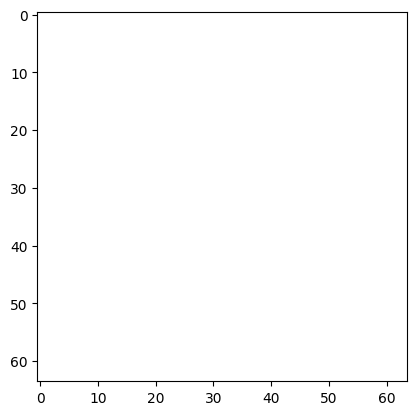

In [24]:
show_video(gt[2].cpu())

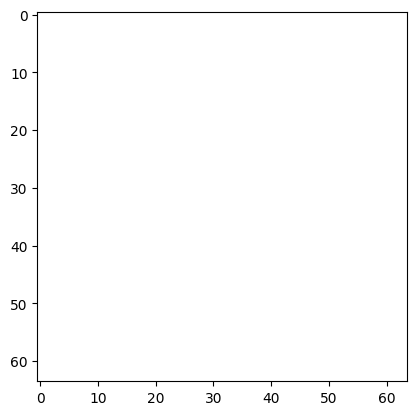

In [25]:
show_video(output[2].cpu().detach())

In [ ]:
show_video(batch[0][0].detach())
